# Overview
The purpose of this notebook is to preprocess the data, build predictive models and evaluate their results.

## Results
MAE For Each model, after hyperparamter optimization:

    -Predicting 2016's Values: 0.875
    -Ridge Regression: 0.804
    -Feedforward Net: 0.801
    -LSTM Neural Net with Sequence Length (on Average):
        -n=3: 0.808
        -n=4: 0.786
        -n=5: 0.791
        -n=6: This one has large swings, because it overfits
        
 An LSTM Model with 4 year long sequences yields the lowest MAE and most stable output and is selected as the final model.

# Code Navigation
* [1. Load Packages & Data](#1.LoadPackages&Data)
* [2. Preprocessing](#2.Preprocessing)
    * [2.1. Drop columns, encode cateogrical variables, plot histograms](#2.1.Dropcolumns,encodecateogricalvariables,plothistograms)
    * [2.2. Apply Log Transform](#2.2.ApplyLogTransform)
    * [2.3. Add previous years data (x3)](#2.3.Addpreviousyearsdata(x3))
    * [2.4. Apply Min/Max Scaling](#2.4.ApplyMin/MaxScaling)
    * [2.4. Test/Train Splits](#2.4.Test/TrainSplits)
* [3. Modeling](#3.Modeling)
    * [3.1. Predicting 2016's Values](#3.1.Predicting2016'sValues)
    * [3.2. Ridge Regression All Counties](#3.2.RidgeRegressionAllCounties)
    * [3.3. Feedforward Neural Net](#3.3.FeedforwardNeuralNet)
    * [3.4. LSTM Neural Net:  n=3](#3.4.LSTMNeuralNet:n=3)
    * [3.5. LSTM Neural Net:  n=4](#3.5.LSTMNeuralNet:n=4)
    * [3.6. LSTM Neural Net:  n=6](#3.6.LSTMNeuralNet:n=6)
    * [3.7. LSTM Neural Net:  n=5](#3.7.LSTMNeuralNet:n=5)
* [4. Compare Model Performance](#4.CompareModelPerformance)

## 1. Load Packages & Data <a class="anchor" id="1.LoadPackages&Data"></a>

In [1]:
import requests
import pandas as pd
from pandas import concat
import csv
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import json

In [2]:
#Set Seaborn Styles
sns.set(font_scale=1.75)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

#Change directory to project root directory
os.chdir("..")

#Import custom code
from src.code_flow.CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2
from src.models.LSTM_Model import *

In [3]:
#Import sklearn
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#Import tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [4]:
df=pd.read_csv('data/interim/post_eda_diabetes_ACS_populous_counties_2004to2019.csv',index_col=0)

In [5]:
df.head(15)

,state,county,region,county_fips,state_fips,total_pop,female,male,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,diabetes_%,diabetes_%_lower,diabetes_%_upper,state_county_fips,years_since_2006
14,Alabama,baldwin county,South,3,1,169162.0,50.75,49.25,87.63,10.15,1.16,0.0,0.56,2.47,1.97,6.65,13.20,13.94,14.19,11.71,8.35,6.28,1.32,44878.0,25.8,86.7,7.2,5.7,9.0,1 3,-2.0
15,Alabama,baldwin county,South,3,1,169162.0,50.75,49.25,87.63,10.15,1.16,0.0,0.56,2.47,1.97,6.65,13.20,13.94,14.19,11.71,8.35,6.28,1.32,44878.0,25.8,86.7,7.2,5.8,8.9,1 3,-1.0
16,Alabama,baldwin county,South,3,1,169162.0,50.75,49.25,87.63,10.15,1.16,0.0,0.56,2.47,1.97,6.65,13.20,13.94,14.19,11.71,8.35,6.28,1.32,44878.0,25.8,86.7,7.8,6.2,9.6,1 3,0.0
17,Alabama,baldwin county,South,3,1,171769.0,51.00,49.00,87.43,10.48,0.92,0.0,0.35,2.69,1.46,5.56,13.37,13.40,14.03,11.31,8.51,6.09,1.81,49119.0,26.4,88.3,8.1,6.7,9.7,1 3,1.0
18,Alabama,baldwin county,South,3,1,174439.0,50.72,49.28,87.42,10.08,1.78,0.0,0.90,2.88,1.51,4.95,14.46,13.43,13.49,11.35,8.61,6.29,1.62,52320.0,29.5,87.9,8.6,7.1,10.0,1 3,2.0
19,Alabama,baldwin county,South,3,1,179878.0,51.15,48.85,86.89,10.19,0.97,0.0,0.82,3.31,1.98,5.37,12.61,12.88,14.33,12.52,9.66,5.37,2.04,48487.0,26.5,89.2,9.9,8.5,11.5,1 3,3.0
20,Alabama,baldwin county,South,3,1,183195.0,50.91,49.09,88.50,9.86,1.29,0.0,0.95,4.41,0.99,4.60,11.77,12.89,14.89,13.57,9.99,5.01,1.73,47502.0,27.2,87.7,10.2,8.7,11.9,1 3,4.0
21,Alabama,baldwin county,South,3,1,186717.0,51.74,48.26,88.03,10.08,1.27,0.0,0.96,4.53,0.92,4.86,12.53,12.66,14.38,13.76,9.84,5.13,1.98,50900.0,28.3,90.4,9.8,8.3,11.4,1 3,5.0
22,Alabama,baldwin county,South,3,1,190790.0,50.95,49.05,88.70,10.19,1.29,0.0,1.21,4.58,1.22,5.77,11.87,11.82,14.87,13.65,10.65,5.32,1.77,48378.0,29.1,89.2,9.1,7.6,10.6,1 3,6.0
23,Alabama,baldwin county,South,3,1,195540.0,51.47,48.53,87.64,10.91,0.31,0.0,1.12,4.58,1.17,6.31,11.80,12.33,12.99,13.98,10.74,5.05,2.17,44874.0,29.0,90.6,8.8,7.3,10.2,1 3,7.0


## 2. Preprocessing <a class="anchor" id="2.Preprocessing"></a>

## 2.1. Drop columns, encode cateogrical variables, plot histograms <a class="anchor" id="2.1.Dropcolumns,encodecateogricalvariables,plothistograms"></a>

In [6]:
#Combine state & county fips
df.state_fips=df.state_fips.astype('int')
df.county_fips=df.county_fips.astype('int')
df['state_county_fips']=df.state_fips.astype('str')+' '+df.county_fips.astype('str')
#Save a dataframe with just state/county names and fips
df_names=df[['state','county','state_fips','county_fips','state_county_fips']]
#Drop columns not to be included in the model 
col=['state','county','state_fips','county_fips','diabetes_%_lower', 'diabetes_%_upper','male']
df.drop(columns=col,inplace=True)
#Encode Region variable
df=pd.get_dummies(df,drop_first=True,columns=['region'])
#Check variables types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11298 entries, 14 to 46699
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_pop           11298 non-null  float64
 1   female              11298 non-null  float64
 2   white_pop           11298 non-null  float64
 3   black_pop           11298 non-null  float64
 4   amer_indian_pop     11298 non-null  float64
 5   pacific_island_pop  11298 non-null  float64
 6   asian_pop           11298 non-null  float64
 7   hispanic_pop        11298 non-null  float64
 8   other_pop           11298 non-null  float64
 9   20_24_years         11298 non-null  float64
 10  25_34_years         11298 non-null  float64
 11  35_44_years         11298 non-null  float64
 12  45_54_years         11298 non-null  float64
 13  55_64_years         11298 non-null  float64
 14  65_74_years         11298 non-null  float64
 15  75_84_years         11298 non-null  float64
 16  85_

In [7]:
df.reset_index(drop=True,inplace=True)
df_raw=df.copy()

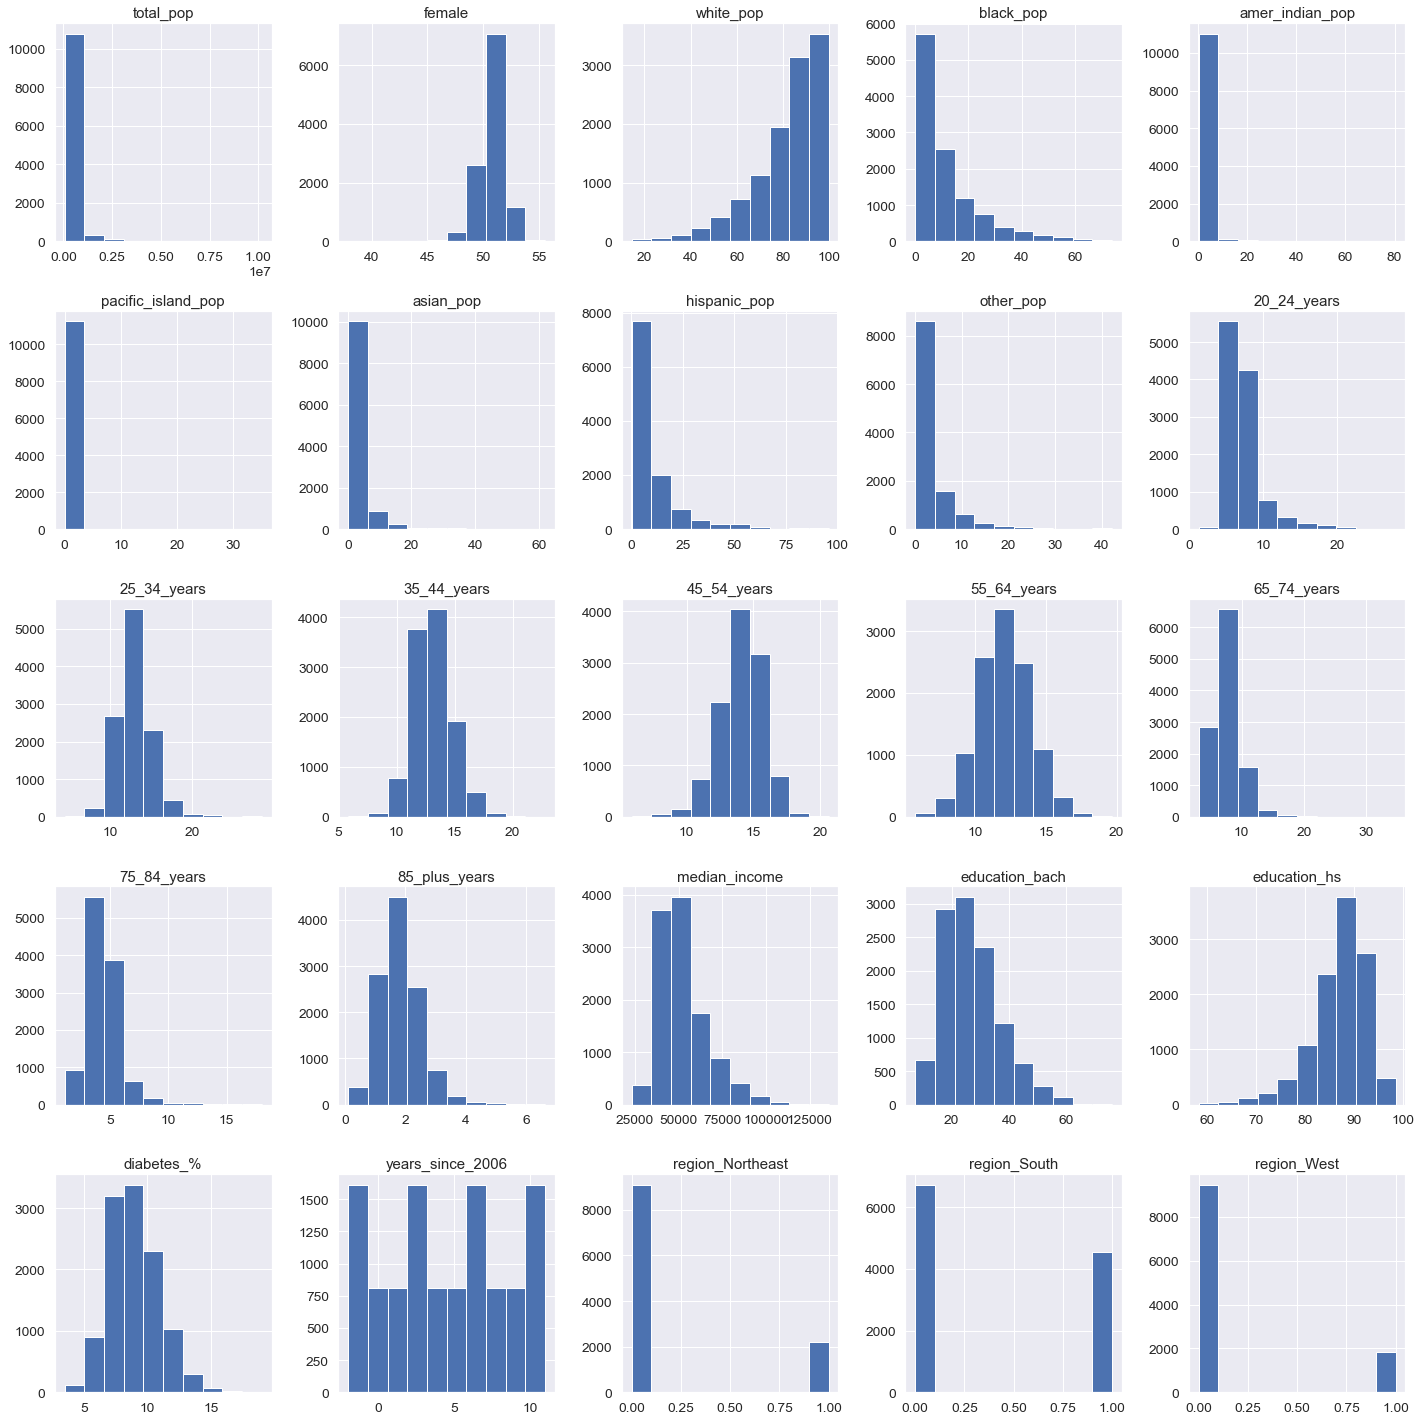

In [8]:
#Visualize Distributions
sns.set(font_scale=1.25)
df.hist(figsize=(20,20))
plt.tight_layout()
plt.show()

## 2.2. Apply Log Transform <a class="anchor" id="2.2.ApplyLogTransform"></a>

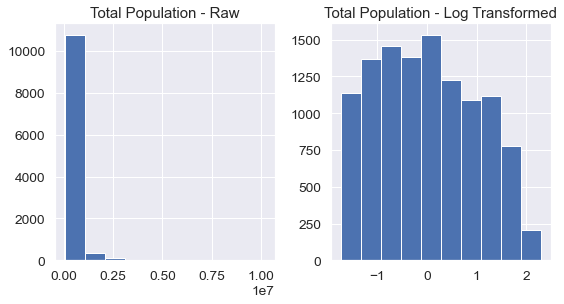

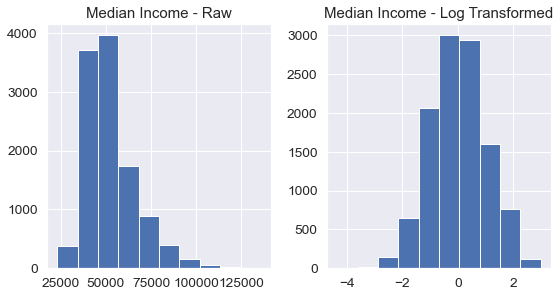

In [9]:
#Visualize log transform on variables that look like they could use them
pt=PowerTransformer(method='box-cox')
q=np.array(df.total_pop).reshape(-1,1)
w=pt.fit_transform(q)

plt.subplots(figsize=(8,8))
plt.subplot(2,2,1)
plt.hist(q)
plt.title('Total Population - Raw')
plt.subplot(2,2,2)
plt.hist(w)
plt.title('Total Population - Log Transformed')
plt.tight_layout()

pt=PowerTransformer(method='box-cox')
q=np.array(df.median_income).reshape(-1,1)
w=pt.fit_transform(q)

plt.subplots(figsize=(8,8))
plt.subplot(2,2,3)
plt.hist(q)
plt.title('Median Income - Raw')
plt.subplot(2,2,4)
plt.hist(w)
plt.title('Median Income - Log Transformed')
plt.tight_layout()

plt.show()

In [10]:
#function for applying log transform to desired columns in a dataframe
def log_transform(variable,df):
    pt=PowerTransformer(method='box-cox')
    q=np.array(df[variable]).reshape(-1,1)
    w=pt.fit_transform(q)
    df.loc[:,variable]=w
    return df

In [11]:
#Apply log transform to total population and median income to normalize them 
df=log_transform('total_pop',df)
df=log_transform('median_income',df)

## 2.3. Add previous years data (x3) <a class="anchor" id="2.3.Addpreviousyearsdata(x3)"></a>

In [12]:
df_test=df[['state_county_fips','years_since_2006','diabetes_%']]
df_test['one_year_past']=df['years_since_2006']+1
df_test['two_years_past']=df['years_since_2006']+2
df_test['three_years_past']=df['years_since_2006']+3
df_test=df_test.drop(columns=['years_since_2006']).rename(columns={'diabetes_%':'diabetes_past'})

a=['two_years_past','three_years_past']
b=['one_year_past','three_years_past']
c=['one_year_past','two_years_past']

df=df.merge(df_test.drop(columns=a),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['one_year_past','state_county_fips']).drop(
            columns=['one_year_past']).rename(columns={'diabetes_past':'diabetes_1_year_past'})
df=df.merge(df_test.drop(columns=b),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['two_years_past','state_county_fips']).drop(
            columns=['two_years_past']).rename(columns={'diabetes_past':'diabetes_2_years_past'})
df=df.merge(df_test.drop(columns=c),how='left',left_on=['years_since_2006','state_county_fips'],
            right_on=['three_years_past','state_county_fips']).drop(
            columns=['three_years_past']).rename(columns={'diabetes_past':'diabetes_3_years_past'})

In [13]:
#Check work 
df[['years_since_2006','diabetes_%','diabetes_1_year_past','diabetes_2_years_past','diabetes_3_years_past']].head(8)

,years_since_2006,diabetes_%,diabetes_1_year_past,diabetes_2_years_past,diabetes_3_years_past
0,-2.0,7.2,NaN,NaN,NaN
1,-1.0,7.2,7.2,NaN,NaN
2,0.0,7.8,7.2,7.2,NaN
3,1.0,8.1,7.8,7.2,7.2
4,2.0,8.6,8.1,7.8,7.2
5,3.0,9.9,8.6,8.1,7.8
6,4.0,10.2,9.9,8.6,8.1
7,5.0,9.8,10.2,9.9,8.6


## 2.4. Apply Min/Max Scaling <a class="anchor" id="2.4.ApplyMin/MaxScaling"></a>

In [14]:
#mm=StandardScaler()
mm=MinMaxScaler()

#Drop state/county fips columns b/c they are strings, as well as the diabetes % because it is the variable to be predicted
df_label=df[['state_county_fips','diabetes_%']]
df_interim=df.copy()
df_interim.drop(columns=['state_county_fips','diabetes_%'],inplace=True)

#Get the column names from the dataframes
df_col=df_interim.columns

#Apply fit/transform to the data 
df_interim=mm.fit_transform(df_interim)

#Make the data back into a dataframe
df_interim=pd.DataFrame(df_interim,columns=df_col)

#Add back the state/county fips columns 
df=pd.concat([df_interim,df_label],axis=1)

In [15]:
#Get list of new years since 2006 unique values
years_scaled_list=list(df.years_since_2006.unique())

## 2.5. Test/Train Splits <a class="anchor" id="2.5.Test/TrainSplits"></a>


In [16]:
#Create a new df with years past diabetes values dropped, which will be used for the LSTM model 
cols=['diabetes_1_year_past','diabetes_2_years_past','diabetes_3_years_past']
df_=df.drop(columns=cols)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11298 entries, 0 to 11297
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_pop              11298 non-null  float64
 1   female                 11298 non-null  float64
 2   white_pop              11298 non-null  float64
 3   black_pop              11298 non-null  float64
 4   amer_indian_pop        11298 non-null  float64
 5   pacific_island_pop     11298 non-null  float64
 6   asian_pop              11298 non-null  float64
 7   hispanic_pop           11298 non-null  float64
 8   other_pop              11298 non-null  float64
 9   20_24_years            11298 non-null  float64
 10  25_34_years            11298 non-null  float64
 11  35_44_years            11298 non-null  float64
 12  45_54_years            11298 non-null  float64
 13  55_64_years            11298 non-null  float64
 14  65_74_years            11298 non-null  float64
 15  75

In [18]:
df.head()

,total_pop,female,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,years_since_2006,region_Northeast,region_South,region_West,diabetes_1_year_past,diabetes_2_years_past,diabetes_3_years_past,state_county_fips,diabetes_%
0,0.449152,0.728717,0.857813,0.135980,0.013073,0.0,0.007267,0.024686,0.045314,0.202484,0.363105,0.477902,0.562246,0.427443,0.165666,0.304683,0.186544,0.530768,0.269679,0.706468,0.000000,0.0,1.0,0.0,NaN,NaN,NaN,1 3,7.2
1,0.449152,0.728717,0.857813,0.135980,0.013073,0.0,0.007267,0.024686,0.045314,0.202484,0.363105,0.477902,0.562246,0.427443,0.165666,0.304683,0.186544,0.530768,0.269679,0.706468,0.076923,0.0,1.0,0.0,0.228758,NaN,NaN,1 3,7.2
2,0.449152,0.728717,0.857813,0.135980,0.013073,0.0,0.007267,0.024686,0.045314,0.202484,0.363105,0.477902,0.562246,0.427443,0.165666,0.304683,0.186544,0.530768,0.269679,0.706468,0.153846,0.0,1.0,0.0,0.228758,0.284553,NaN,1 3,7.8
3,0.454257,0.742906,0.855468,0.140468,0.010085,0.0,0.003876,0.026987,0.033215,0.161460,0.370200,0.446081,0.551421,0.398707,0.170724,0.293420,0.261468,0.584946,0.278426,0.746269,0.230769,0.0,1.0,0.0,0.267974,0.284553,0.299145,1 3,8.1
4,0.459363,0.727015,0.855351,0.135029,0.020792,0.0,0.012758,0.028975,0.034401,0.138502,0.415693,0.447849,0.514885,0.401580,0.173886,0.305276,0.232416,0.620736,0.323615,0.736318,0.307692,0.0,1.0,0.0,0.287582,0.333333,0.299145,1 3,8.6


In [19]:
#Reset the index & Drop rows with NaNs; these correspond to the 2004, 2005 & 2006 years. 
df=df.dropna().reset_index(drop=True)

In [20]:
#Make train/test set for regression & dense neural net
df_2006_2016=df[df.years_since_2006<1].reset_index(drop=True)
df_2017=df[df.years_since_2006==1].reset_index(drop=True)
#df_2018_2019=df[df.years_since_2006>11].reset_index(drop=True).drop(columns=['diabetes_%'])

## 3. Modeling <a class="anchor" id="3.Modeling"></a>

## 3.1. Predicting 2016's Values <a class="anchor" id="3.1.Predicting2016'sValues"></a>

In [21]:
#Function for calculating MAE 
def MAE(df):
    return(np.mean(np.abs(df.diabetes_pred-df.diabetes_actual_2017)))

In [22]:
#Deterime mean absolute difference between predicting 2016's value for 2017
#Select 2016 diabetes/state county fips data
df_pred=df_2006_2016[df_2006_2016.years_since_2006==df_2006_2016.years_since_2006.max()][['state_county_fips','diabetes_%']].rename(columns={'diabetes_%':'diabetes_pred'})
#Select 2017 diabetes/state county fips data
df_actual=df_2017[['state_county_fips','diabetes_%']].rename(columns={'diabetes_%':'diabetes_actual_2017'})
#Concatenate the two and calculate the mean absolute error
df_pred_actual=df_pred.merge(df_actual,how='inner',right_on='state_county_fips',left_on='state_county_fips')
print('Using 2016 values as a prediction for 2017 results in an MAE of',round(MAE(df_pred_actual),5))

Using 2016 values as a prediction for 2017 results in an MAE of 0.8746


## 3.2. Ridge Regression All Counties <a class="anchor" id="3.2.RidgeRegressionAllCounties"></a>

### Ridge Regression

In [23]:
X_train=df_2006_2016.drop(columns=['diabetes_%','state_county_fips'])
y_train=df_2006_2016[['diabetes_%']]
X_test=df_2017.drop(columns=['diabetes_%','state_county_fips'])
y_test=df_2017[['diabetes_%']]

i=[1]+[1/(10**j) for j in range (1,8)]
results={}

for alpha in i:
    clf=Ridge(alpha=alpha)
    clf.fit(X_train,y_train)
    pred=pd.DataFrame(clf.predict(X_test))
    df_temp=pd.concat([pred,y_test],axis=1).rename(columns={0:'diabetes_pred','diabetes_%':'diabetes_actual_2017'})
    results[alpha]=MAE(df_temp)

alpha_best=min(results,key=results.get)

In [24]:
#Create Model based on best alpha 
clf=Ridge(alpha=alpha_best)
clf.fit(X_train,y_train)
pred=pd.DataFrame(clf.predict(X_test))
df_temp=pd.concat([pred,y_test],axis=1).rename(columns={0:'diabetes_pred','diabetes_%':'diabetes_actual_2017'})
results[alpha]=MAE(df_temp)

In [25]:
#Model Coefficients - Note they are sorted by ABSOLUTE value.
clf_coef=pd.DataFrame([X_train.columns,clf.coef_.T]).T.rename(columns={0:'Feature',1:'Coefficient'})
clf_coef.reindex(clf_coef.Coefficient.abs().sort_values(ascending=False).index)

,Feature,Coefficient
24,diabetes_1_year_past,[12.88686701226523]
18,education_bach,[-1.362412827915762]
26,diabetes_3_years_past,[-1.348861333363724]
7,hispanic_pop,[-0.8407621200811116]
25,diabetes_2_years_past,[0.779002301608746]
4,amer_indian_pop,[0.6361382290824514]
17,median_income,[-0.6350155226495989]
6,asian_pop,[0.5623975488746945]
3,black_pop,[0.5252997130072462]
20,years_since_2006,[0.4730568068488451]


In [26]:
#evaluate model performance
mae_best=results[alpha_best]
print('A single Ridge regression model results in a best MAE of {}. The alpha value used was {}'.format(round(float(mae_best),5),alpha_best))

A single Ridge regression model results in a best MAE of 0.80129. The alpha value used was 1


In [27]:
#fit a linear regression model using stats models to returns stats on coefficients
X_train2 = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train2)
results = model.fit()

print (results.summary())

                            OLS Regression Results                            
Dep. Variable:             diabetes_%   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     2164.
Date:                Wed, 28 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:52:14   Log-Likelihood:                -7970.8
No. Observations:                8070   AIC:                         1.600e+04
Df Residuals:                    8042   BIC:                         1.619e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.13

In [28]:
#fit regularized model, return coefficients
#note: at the moment, stats mdoels doesn't give summary stats for regualrized models 
res=model.fit_regularized(alpha=1,L1_wt=0)
res.params

array([1.44879947, 0.50476569, 1.06894974, 1.05300099, 0.35071095,
       0.05149189, 0.01148435, 0.04792159, 0.13699996, 0.10359567,
       0.33538892, 0.5153512 , 0.58632407, 0.76536185, 0.65458991,
       0.21435439, 0.28016318, 0.36237856, 0.73361098, 0.27158119,
       0.9315422 , 0.83692984, 0.16944415, 0.82397635, 0.0996583 ,
       0.67320975, 0.79606604, 0.79273592])

## 3.3.Feedforward Neural Net  <a class="anchor" id="3.3.DenseNeuralNet"></a>

In [29]:
#create model
model = Sequential()
model.add(Dense(100, activation=tf.nn.relu, input_shape=[len(X_train.columns)]))
model.add(Dense(100, activation=tf.nn.relu))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#Prevent Overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
model_check=keras.callbacks.ModelCheckpoint('models/all_models/best_model_Dense.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[early_stop,model_check])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 8070 samples, validate on 807 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.55677, saving model to models/all_models/best_model_Dense.hdf5
8070/8070 - 0s - loss: 3.0173 - val_loss: 1.5568
Epoch 2/100

Epoch 00002: val_loss improved from 1.55677 to 1.26861, saving model to models/all_models/best_model_Dense.hdf5
8070/8070 - 0s - loss: 1.0797 - val_loss: 1.2686
Epoch 3/100

Epoch 00003: val_loss improved from 1.26861 to 1.11639, saving model to models/all_models/best_model_Dense.hdf5
8070/8070 - 0s - loss: 0.8901 - val_loss: 1.1164
Epoch 4/100

Epoch 00004: val_loss improved from 1.11639 to 1.00788, saving model to models/all_models/best_model_Dense.hdf5
8070/8070 - 0s - loss: 0.7149 - val_loss: 1.0079
Epoch 5/100

Epoch 00005: val_loss improved from 1.00788 to 0.95431, saving model to models/all_models/best_model_Dense.hdf5
8070/8070 - 0s - l

Epoch 53/100

Epoch 00053: val_loss did not improve from 0.80140
8070/8070 - 0s - loss: 0.4816 - val_loss: 0.8015
Epoch 54/100

Epoch 00054: val_loss improved from 0.80140 to 0.79922, saving model to models/all_models/best_model_Dense.hdf5
8070/8070 - 0s - loss: 0.4829 - val_loss: 0.7992
Epoch 55/100

Epoch 00055: val_loss did not improve from 0.79922
8070/8070 - 0s - loss: 0.4839 - val_loss: 0.8043
Epoch 56/100

Epoch 00056: val_loss did not improve from 0.79922
8070/8070 - 0s - loss: 0.5276 - val_loss: 0.8466
Epoch 57/100

Epoch 00057: val_loss did not improve from 0.79922
8070/8070 - 0s - loss: 0.5503 - val_loss: 0.8709
Epoch 58/100

Epoch 00058: val_loss did not improve from 0.79922
8070/8070 - 0s - loss: 0.5720 - val_loss: 0.8522
Epoch 59/100

Epoch 00059: val_loss did not improve from 0.79922
8070/8070 - 0s - loss: 0.5415 - val_loss: 0.8140
Epoch 60/100

Epoch 00060: val_loss did not improve from 0.79922
8070/8070 - 0s - loss: 0.5010 - val_loss: 0.8069
Epoch 61/100

Epoch 00061: 

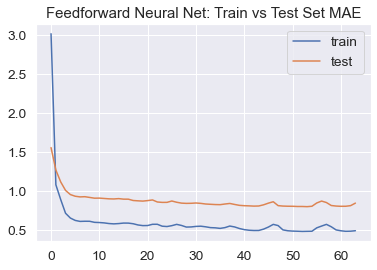

In [30]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Feedforward Neural Net: Train vs Test Set MAE')
plt.legend()
plt.show()

In [31]:
#evaluate model perfomance
model.load_weights('models/all_models/best_model_Dense.hdf5')
mae = model.evaluate(X_test,y_test,verbose=0)
print('A feedforward net results an MAE of {}.'.format(mae))

A feedforward net results an MAE of 0.7992223693609534.


In [32]:
#Code for generating 50 models and saving the mae
#Commented out because it takes awhile to run
#Results saved in mae.json file 
'''
mae_list_dense=[]
for i in tqdm(range(50)):
    model = Sequential()
    model.add(Dense(100, activation=tf.nn.relu, input_shape=[len(X_train.columns)]))
    model.add(Dense(100, activation=tf.nn.relu, input_shape=[len(X_train.columns)]))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    #Prevent Overfitting
    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    model_check=keras.callbacks.ModelCheckpoint('models/best_model_Dense.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    # fit network
    history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                        validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[early_stop,model_check])
    model.load_weights('models/best_model_Dense.hdf5')
    mae = model.evaluate(X_test,y_test,verbose=0)
    mae_list_dense.append(mae)
'''

"\nmae_list_dense=[]\nfor i in tqdm(range(50)):\n    model = Sequential()\n    model.add(Dense(100, activation=tf.nn.relu, input_shape=[len(X_train.columns)]))\n    model.add(Dense(100, activation=tf.nn.relu, input_shape=[len(X_train.columns)]))\n    model.add(Dense(1))\n    model.compile(loss='mae', optimizer='adam')\n    #Prevent Overfitting\n    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)\n    model_check=keras.callbacks.ModelCheckpoint('models/best_model_Dense.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)\n    # fit network\n    history = model.fit(X_train, y_train, epochs=100, batch_size=72, \n                        validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[early_stop,model_check])\n    model.load_weights('models/best_model_Dense.hdf5')\n    mae = model.evaluate(X_test,y_test,verbose=0)\n    mae_list_dense.append(mae)\n"

## 3.4.  LSTM Neural Net:  n=3  <a class="anchor" id="3.4.LSTMNeuralNet:n=3"></a>

In [33]:
#Make a copy of raw data frame, specify length of sequence to be fed into LSTM 
df_copy=df_.copy()
n=2

def sts_wrappper(df):
    df = series_to_supervised(df, 'diabetes_%', n, concat)
    return df

In [34]:
#Get shifted values by county
df_=df_.groupby('state_county_fips').apply(sts_wrappper)
df_.reset_index(drop=True,inplace=True)
#Drop rows missing the earliest diabetes values 
df_.dropna(subset=['diabetes_%(t-{})'.format(n+1)],inplace=True)
#Drop rows containing 2005 data the earliest slot 
df_=df_[df_['years_since_2006(t-{})'.format(n)]>0.1]
df_.reset_index(drop=True,inplace=True)

In [35]:
#get test/train sets using custom test train split function
X_train,y_train,X_test,y_test=test_train_split(df_,df_copy,n,years_scaled_list,np)

X_train shape: (7263, 3, 25)  y_train shape: (7263,)
X_test shape: (807, 3, 25)  y_test shape: (807,)


In [36]:
#create model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#Prevent Overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
model_check=keras.callbacks.ModelCheckpoint('models/all_models/best_model_LSTM_3.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[early_stop,model_check])

Train on 7263 samples, validate on 807 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.94133, saving model to models/all_models/best_model_LSTM_3.hdf5
7263/7263 - 1s - loss: 4.4547 - val_loss: 1.9413
Epoch 2/100

Epoch 00002: val_loss improved from 1.94133 to 1.80638, saving model to models/all_models/best_model_LSTM_3.hdf5
7263/7263 - 0s - loss: 1.4424 - val_loss: 1.8064
Epoch 3/100

Epoch 00003: val_loss improved from 1.80638 to 1.14581, saving model to models/all_models/best_model_LSTM_3.hdf5
7263/7263 - 0s - loss: 0.8961 - val_loss: 1.1458
Epoch 4/100

Epoch 00004: val_loss improved from 1.14581 to 1.02008, saving model to models/all_models/best_model_LSTM_3.hdf5
7263/7263 - 0s - loss: 0.6738 - val_loss: 1.0201
Epoch 5/100

Epoch 00005: val_loss improved from 1.02008 to 0.96960, saving model to models/all_models/best_model_LSTM_3.hdf5
7263/7263 - 0s - loss: 0.5827 - val_l

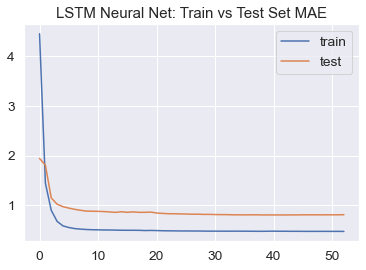

In [37]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM Neural Net: Train vs Test Set MAE')
plt.legend()
plt.show()

In [38]:
#evaluate model perfomance
model.load_weights('models/all_models/best_model_LSTM_3.hdf5')
mae = model.evaluate(X_test,y_test,verbose=0)
print('A single neural net model results an MAE of {}.'.format(mae))

A single neural net model results an MAE of 0.802606455012325.


## 3.5.  LSTM Neural Net:  n=4  <a class="anchor" id="3.5.LSTMNeuralNet:n=4"></a>

In [39]:
#Recopy raw data frame, specify length of sequence to be fed into LSTM 
df_=df_copy.copy()
n=3

def sts_wrappper(df):
    df = series_to_supervised(df, 'diabetes_%', n, concat)
    return df

In [40]:
#Get shifted values by county
df_=df_.groupby('state_county_fips').apply(sts_wrappper)
df_.reset_index(drop=True,inplace=True)
#Drop rows missing the earliest diabetes values 
df_.dropna(subset=['diabetes_%(t-{})'.format(n+1)],inplace=True)
#Drop rows containing 2005 data the earliest slot 
df_=df_[df_['years_since_2006(t-{})'.format(n)]>0.1]
df_.reset_index(drop=True,inplace=True)

In [41]:
#get test/train sets using custom test train split function
X_train,y_train,X_test,y_test=test_train_split(df_,df_copy,n,years_scaled_list,np)

X_train shape: (6456, 4, 25)  y_train shape: (6456,)
X_test shape: (807, 4, 25)  y_test shape: (807,)


In [42]:
#create model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#Prevent Overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
model_check=keras.callbacks.ModelCheckpoint('models/all_models/best_model_LSTM_4.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=[early_stop,model_check])

Train on 6456 samples, validate on 807 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.95835, saving model to models/all_models/best_model_LSTM_4.hdf5
6456/6456 - 1s - loss: 4.0508 - val_loss: 1.9584
Epoch 2/100

Epoch 00002: val_loss improved from 1.95835 to 1.90199, saving model to models/all_models/best_model_LSTM_4.hdf5
6456/6456 - 0s - loss: 1.4686 - val_loss: 1.9020
Epoch 3/100

Epoch 00003: val_loss improved from 1.90199 to 1.22130, saving model to models/all_models/best_model_LSTM_4.hdf5
6456/6456 - 0s - loss: 1.0498 - val_loss: 1.2213
Epoch 4/100

Epoch 00004: val_loss improved from 1.22130 to 1.07191, saving model to models/all_models/best_model_LSTM_4.hdf5
6456/6456 - 0s - loss: 0.6989 - val_loss: 1.0719
Epoch 5/100

Epoch 00005: val_loss improved from 1.07191 to 1.01008, saving model to models/all_models/best_model_LSTM_4.hdf5
6456/6456 - 0s - loss: 0.6096 - val_loss: 1.0101
Epoch 6/100

Epoch 00006: val_loss improved from 1.01008 to 0.96275, saving model 

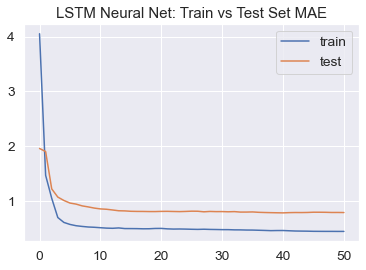

In [43]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM Neural Net: Train vs Test Set MAE')
plt.legend()
plt.show()

In [44]:
#evaluate model perfomance
model.load_weights('models/all_models/best_model_LSTM_4.hdf5')
mae = model.evaluate(X_test,y_test,verbose=0)
print('A single neural net model results an MAE of {}.'.format(mae))

A single neural net model results an MAE of 0.7838470471983653.


In [45]:
#Code for generating 50 models and saving the mae
#Commented out because it takes over an hour to run
#Results saved in mae.json file 
'''
mae_list_n3=[]
for i in tqdm(range(50)):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
                  
    #Prevent Overfitting
    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    model_check=keras.callbacks.ModelCheckpoint('models/best_model_LSTM_4.hdf5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
                  
    # fit network
    history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                        validation_data=(X_test, y_test), verbose=0, shuffle=False, callbacks=[early_stop,model_check])
    model.load_weights('models/best_model_LSTM_4.hdf5')
    mae = model.evaluate(X_test,y_test,verbose=0)
    mae_list_n3.append(mae)
'''

"\nmae_list_n3=[]\nfor i in tqdm(range(50)):\n    model = Sequential()\n    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))\n    model.add(Dense(1))\n    model.compile(loss='mae', optimizer='adam')\n                  \n    #Prevent Overfitting\n    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)\n    model_check=keras.callbacks.ModelCheckpoint('models/best_model_LSTM_4.hdf5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)\n                  \n    # fit network\n    history = model.fit(X_train, y_train, epochs=100, batch_size=72, \n                        validation_data=(X_test, y_test), verbose=0, shuffle=False, callbacks=[early_stop,model_check])\n    model.load_weights('models/best_model_LSTM_4.hdf5')\n    mae = model.evaluate(X_test,y_test,verbose=0)\n    mae_list_n3.append(mae)\n"

## 3.6.  LSTM Neural Net:  n=6  <a class="anchor" id="3.6.LSTMNeuralNet:n=6"></a>

In [46]:
#Recopy raw data frame, specify length of sequence to be fed into LSTM 
df_=df_copy.copy()
n=5

def sts_wrappper(df):
    df = series_to_supervised(df, 'diabetes_%', n, concat)
    return df

In [47]:
#Get shifted values by county
df_=df_.groupby('state_county_fips').apply(sts_wrappper)
df_.reset_index(drop=True,inplace=True)
#Drop rows missing the earliest diabetes values 
df_.dropna(subset=['diabetes_%(t-{})'.format(n+1)],inplace=True)
#Drop rows containing 2005 data the earliest slot 
df_=df_[df_['years_since_2006(t-{})'.format(n)]>0.1]
df_.reset_index(drop=True,inplace=True)

In [48]:
#get test/train sets using custom test train split function
X_train,y_train,X_test,y_test=test_train_split(df_,df_copy,n,years_scaled_list,np)

X_train shape: (4842, 6, 25)  y_train shape: (4842,)
X_test shape: (807, 6, 25)  y_test shape: (807,)


In [49]:
#create model 
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#Prevent Overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
model_check=keras.callbacks.ModelCheckpoint('models/all_models/best_model_LSTM_6.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[early_stop,model_check])

Train on 4842 samples, validate on 807 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.38497, saving model to models/all_models/best_model_LSTM_6.hdf5
4842/4842 - 1s - loss: 5.6041 - val_loss: 2.3850
Epoch 2/100

Epoch 00002: val_loss improved from 2.38497 to 1.79866, saving model to models/all_models/best_model_LSTM_6.hdf5
4842/4842 - 0s - loss: 1.5717 - val_loss: 1.7987
Epoch 3/100

Epoch 00003: val_loss improved from 1.79866 to 1.71945, saving model to models/all_models/best_model_LSTM_6.hdf5
4842/4842 - 0s - loss: 1.3116 - val_loss: 1.7194
Epoch 4/100

Epoch 00004: val_loss improved from 1.71945 to 1.32173, saving model to models/all_models/best_model_LSTM_6.hdf5
4842/4842 - 0s - loss: 0.9336 - val_loss: 1.3217
Epoch 5/100

Epoch 00005: val_loss improved from 1.32173 to 1.24760, saving model to models/all_models/best_model_LSTM_6.hdf5
4842/4842 - 0s - loss: 0.8101 - val_loss: 1.2476
Epoch 6/100

Epoch 00006: val_loss improved from 1.24760 to 1.14758, saving model 

Epoch 52/100

Epoch 00052: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4797 - val_loss: 0.7909
Epoch 53/100

Epoch 00053: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4793 - val_loss: 0.7948
Epoch 54/100

Epoch 00054: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4786 - val_loss: 0.7975
Epoch 55/100

Epoch 00055: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4775 - val_loss: 0.7910
Epoch 56/100

Epoch 00056: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4769 - val_loss: 0.7978
Epoch 57/100

Epoch 00057: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4762 - val_loss: 0.7900
Epoch 58/100

Epoch 00058: val_loss did not improve from 0.78630
4842/4842 - 0s - loss: 0.4758 - val_loss: 0.7943


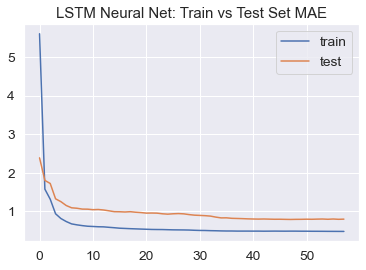

In [50]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM Neural Net: Train vs Test Set MAE')
plt.legend()
plt.show()

In [51]:
#evaluate model perfomance
model.load_weights('models/all_models/best_model_LSTM_6.hdf5')
mae = model.evaluate(X_test,y_test,verbose=0)
print('A single neural net model results an MAE of {}.'.format(mae))

A single neural net model results an MAE of 0.7862998496791835.


## 3.7.  LSTM Neural Net:  n=5  <a class="anchor" id="3.7.LSTMNeuralNet:n=5"></a>

In [52]:
#Recopy raw data frame, specify length of sequence to be fed into LSTM 
df_=df_copy.copy()
n=4

def sts_wrappper(df):
    df = series_to_supervised(df, 'diabetes_%', n, concat)
    return df

In [53]:
#Get shifted values by county
df_=df_.groupby('state_county_fips').apply(sts_wrappper)
df_.reset_index(drop=True,inplace=True)
#Drop rows missing the earliest diabetes values 
df_.dropna(subset=['diabetes_%(t-{})'.format(n+1)],inplace=True)
#Drop rows containing 2005 data the earliest slot 
df_=df_[df_['years_since_2006(t-{})'.format(n)]>0.1]
df_.reset_index(drop=True,inplace=True)

In [54]:
#get test/train sets using custom test train split function
X_train,y_train,X_test,y_test=test_train_split(df_,df_copy,n,years_scaled_list,np)

X_train shape: (5649, 5, 25)  y_train shape: (5649,)
X_test shape: (807, 5, 25)  y_test shape: (807,)


In [55]:
#create model 
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
#Prevent Overfitting
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
model_check=keras.callbacks.ModelCheckpoint('models/all_models/best_model_LSTM_5.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                    validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[early_stop,model_check])

Train on 5649 samples, validate on 807 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.97619, saving model to models/all_models/best_model_LSTM_5.hdf5
5649/5649 - 1s - loss: 3.7753 - val_loss: 1.9762
Epoch 2/100

Epoch 00002: val_loss improved from 1.97619 to 1.91795, saving model to models/all_models/best_model_LSTM_5.hdf5
5649/5649 - 0s - loss: 1.5589 - val_loss: 1.9179
Epoch 3/100

Epoch 00003: val_loss improved from 1.91795 to 1.43991, saving model to models/all_models/best_model_LSTM_5.hdf5
5649/5649 - 0s - loss: 1.2641 - val_loss: 1.4399
Epoch 4/100

Epoch 00004: val_loss improved from 1.43991 to 1.14588, saving model to models/all_models/best_model_LSTM_5.hdf5
5649/5649 - 0s - loss: 0.8202 - val_loss: 1.1459
Epoch 5/100

Epoch 00005: val_loss did not improve from 1.14588
5649/5649 - 0s - loss: 0.7393 - val_loss: 1.1513
Epoch 6/100

Epoch 00006: val_loss improved from 1.14588 to 1.06513, saving model to models/all_models/best_model_LSTM_5.hdf5
5649/5649 - 0s - l

Epoch 56/100

Epoch 00056: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4595 - val_loss: 0.7916
Epoch 57/100

Epoch 00057: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4581 - val_loss: 0.7922
Epoch 58/100

Epoch 00058: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4584 - val_loss: 0.7942
Epoch 59/100

Epoch 00059: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4581 - val_loss: 0.7917
Epoch 60/100

Epoch 00060: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4583 - val_loss: 0.7894
Epoch 61/100

Epoch 00061: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4587 - val_loss: 0.7999
Epoch 62/100

Epoch 00062: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4595 - val_loss: 0.7883
Epoch 63/100

Epoch 00063: val_loss did not improve from 0.78771
5649/5649 - 0s - loss: 0.4561 - val_loss: 0.7886
Epoch 64/100

Epoch 00064: val_loss improved from 0.78771 to 0.78419, saving model to mo

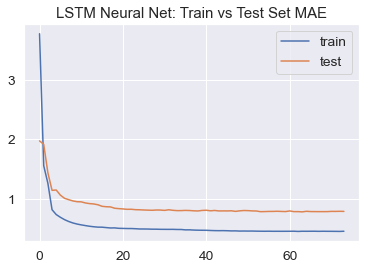

In [56]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('LSTM Neural Net: Train vs Test Set MAE')
plt.legend()
plt.show()

In [57]:
#evaluate model perfomance
model.load_weights('models/all_models/best_model_LSTM_5.hdf5')
mae = model.evaluate(X_test,y_test,verbose=0)
print('A single neural net model results an MAE of {}.'.format(mae))

A single neural net model results an MAE of 0.7841873576280648.


In [58]:
#Code for generating 50 models and saving the mae
#Commented out because it takes over an hour to run
#Results saved in mae.json file 
'''
mae_list_n4=[]
for i in tqdm(range(50)):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
                  
    #Prevent Overfitting
    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    model_check=keras.callbacks.ModelCheckpoint('models/best_model_LSTM_5.hdf5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
                  
    # fit network
    history = model.fit(X_train, y_train, epochs=100, batch_size=72, 
                        validation_data=(X_test, y_test), verbose=0, shuffle=False, callbacks=[early_stop,model_check])
    model.load_weights('models/best_model_LSTM_5.hdf5')
    mae = model.evaluate(X_test,y_test,verbose=0)
    mae_list_n4.append(mae)
'''

"\nmae_list_n4=[]\nfor i in tqdm(range(50)):\n    model = Sequential()\n    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))\n    model.add(Dense(1))\n    model.compile(loss='mae', optimizer='adam')\n                  \n    #Prevent Overfitting\n    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)\n    model_check=keras.callbacks.ModelCheckpoint('models/best_model_LSTM_5.hdf5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)\n                  \n    # fit network\n    history = model.fit(X_train, y_train, epochs=100, batch_size=72, \n                        validation_data=(X_test, y_test), verbose=0, shuffle=False, callbacks=[early_stop,model_check])\n    model.load_weights('models/best_model_LSTM_5.hdf5')\n    mae = model.evaluate(X_test,y_test,verbose=0)\n    mae_list_n4.append(mae)\n"

## 4. Compare Model Performance  <a class="anchor" id="4.CompareModelPerformance"></a>

In [59]:
#Read in mae values for neural net models
with open('data/processed/mae.json','r') as json_file:
    data=json.load(json_file)
mae_list_n3=data['n3']
mae_list_n4=data['n4']
mae_list_dense=data['dense']

Average  STD
0.00709 0.78554


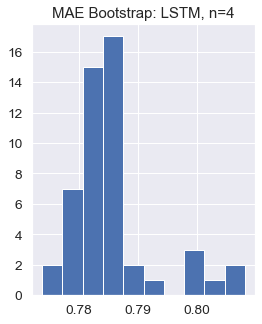

In [60]:
#LSTM, n=4
#Return average, std and histogram of MAE over 50 iterations of this model
print('Average  STD')
print(round(np.std(mae_list_n3),5), round(np.mean(mae_list_n3),5))
plt.subplots(figsize=(4,5))
plt.title('MAE Bootstrap: LSTM, n=4')
plt.hist(mae_list_n3)
plt.show()

Average  STD
0.0113 0.79108


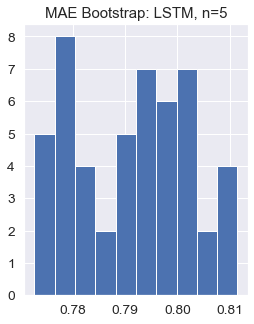

In [61]:
#LSTM, n=5
#Return average, std and histogram of MAE over 50 iterations of this model
print('Average  STD')
print(round(np.std(mae_list_n4),5), round(np.mean(mae_list_n4),5))
plt.subplots(figsize=(4,5))
plt.title('MAE Bootstrap: LSTM, n=5')
plt.hist(mae_list_n4)
plt.show()

Average  STD
0.00486 0.80618


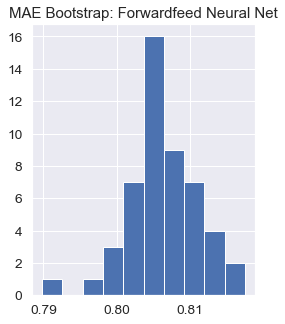

In [62]:
#Forward Feed Neural Net
#Return average, std and histogram of MAE over 50 iterations of this model
print('Average  STD')
print(round(np.std(mae_list_dense),5), round(np.mean(mae_list_dense),5))
plt.subplots(figsize=(4,5))
plt.hist(mae_list_dense)
plt.title('MAE Bootstrap: Forwardfeed Neural Net')
plt.show()

In [63]:
#Load n=4 Model 
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.load_weights('models/all_models/best_model_LSTM_4.hdf5')
mae = model.evaluate(X_test,y_test,verbose=0)
print('A single neural net model results an MAE of {}.'.format(mae))

A single neural net model results an MAE of 0.828564472025655.


In [64]:
#Merge model & 2016 predictions with actual values for 2017. 
#Get model's prediction for 2017
y_pred_model=pd.Series(model.predict(X_test).reshape(len(y_test)),name='diabetes_pred_model')

#Get 2016 values
y_pred_2016=df_raw[df_raw.years_since_2006==10][['diabetes_%','state_county_fips']].rename(columns={'diabetes_%':'diabetes_2016'})

#Get all original rows for 2017 & reset index
df_2017=df_raw[df_raw.years_since_2006==11].reset_index(drop=True)

#Add the model prediction column to dataframe
df_2017=pd.concat([df_2017,y_pred_model],axis=1)

#Add 2016 values to dataframe
df_2017=df_2017.merge(y_pred_2016,left_on='state_county_fips',right_on='state_county_fips',how='inner')

#Ensure that model predictions were correctly lined up with original dataframe
print(round(np.mean(np.abs(df_2017.diabetes_pred_model-df_2017['diabetes_%'])),6)==round(mae,6))

#Ensure that 2016 predictions were correctly lined up with original dataframe
print(round(np.mean(np.abs(df_2017['diabetes_2016']-df_2017['diabetes_%'])),5)== round(MAE(df_pred_actual),5))

#Add an absolute difference column between actual 2017 diabetes value and the value predicted by the model  
df_2017['diff_model']=np.abs(df_2017['diabetes_%']-df_2017['diabetes_pred_model'])

#Add an absolute difference column between 2017 diabetes value and 2016 diabetes value
df_2017['diff_2016']=np.abs(df_2017['diabetes_%']-df_2017['diabetes_2016'])

False
True


In [65]:
df_2017.head()

,total_pop,female,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,diabetes_%,state_county_fips,years_since_2006,region_Northeast,region_South,region_West,diabetes_pred_model,diabetes_2016,diff_model,diff_2016
0,212628.0,50.76,87.49,9.74,1.30,0.0,1.45,4.55,1.04,4.83,11.96,12.49,12.85,14.22,12.02,6.08,1.90,55342.0,33.6,89.3,8.2,1 3,11.0,0,1,0,8.655484,8.5,0.455484,0.3
1,114728.0,51.77,75.75,22.08,0.66,0.0,1.26,3.75,1.84,6.02,13.16,12.45,12.59,13.74,10.42,4.83,2.16,46763.0,19.3,85.3,15.2,1 15,11.0,0,1,0,14.038418,15.6,1.161582,0.4
2,82755.0,50.49,97.45,1.98,1.30,0.0,0.50,4.33,1.84,6.13,12.56,12.24,13.52,13.69,10.68,6.02,1.27,45044.0,12.4,82.2,13.3,1 43,11.0,0,1,0,14.336666,17.2,1.036666,3.9
3,71617.0,51.68,89.18,1.96,3.19,0.0,0.82,14.84,8.93,6.14,11.02,13.20,12.71,12.84,10.25,5.55,0.90,39373.0,15.1,77.3,14.3,1 49,11.0,0,1,0,11.767742,11.2,2.532258,3.1
4,81677.0,51.47,75.26,22.97,0.46,0.0,0.51,2.99,1.72,6.45,12.68,13.92,13.96,12.89,8.75,4.86,1.24,60558.0,24.9,86.6,13.9,1 51,11.0,0,1,0,13.884943,14.9,0.015057,1.0


In [66]:
#Break the counties into quantile 
df_2017['pop_quantiles']=pd.qcut(df_2017.total_pop,4)
df_2017['pop_quantiles_labels']=pd.qcut(df_2017.total_pop,4,labels=['Small','Medium','Large','Extra Large'])
df_2017['pop_quantiles']=df_2017['pop_quantiles'].astype('category')
df_2017.pop_quantiles.value_counts()

(344996.5, 10163507.0]    202
(98376.5, 161834.0]       202
(61791.999, 98376.5]      202
(161834.0, 344996.5]      201
Name: pop_quantiles, dtype: int64

In [67]:
df_2017.head(10)

,total_pop,female,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,diabetes_%,state_county_fips,years_since_2006,region_Northeast,region_South,region_West,diabetes_pred_model,diabetes_2016,diff_model,diff_2016,pop_quantiles,pop_quantiles_labels
0,212628.0,50.76,87.49,9.74,1.30,0.00,1.45,4.55,1.04,4.83,11.96,12.49,12.85,14.22,12.02,6.08,1.90,55342.0,33.6,89.3,8.2,1 3,11.0,0,1,0,8.655484,8.5,0.455484,0.3,"(161834.0, 344996.5]",Large
1,114728.0,51.77,75.75,22.08,0.66,0.00,1.26,3.75,1.84,6.02,13.16,12.45,12.59,13.74,10.42,4.83,2.16,46763.0,19.3,85.3,15.2,1 15,11.0,0,1,0,14.038418,15.6,1.161582,0.4,"(98376.5, 161834.0]",Medium
2,82755.0,50.49,97.45,1.98,1.30,0.00,0.50,4.33,1.84,6.13,12.56,12.24,13.52,13.69,10.68,6.02,1.27,45044.0,12.4,82.2,13.3,1 43,11.0,0,1,0,14.336666,17.2,1.036666,3.9,"(61791.999, 98376.5]",Small
3,71617.0,51.68,89.18,1.96,3.19,0.00,0.82,14.84,8.93,6.14,11.02,13.20,12.71,12.84,10.25,5.55,0.90,39373.0,15.1,77.3,14.3,1 49,11.0,0,1,0,11.767742,11.2,2.532258,3.1,"(61791.999, 98376.5]",Small
4,81677.0,51.47,75.26,22.97,0.46,0.00,0.51,2.99,1.72,6.45,12.68,13.92,13.96,12.89,8.75,4.86,1.24,60558.0,24.9,86.6,13.9,1 51,11.0,0,1,0,13.884943,14.9,0.015057,1.0,"(61791.999, 98376.5]",Small
5,102755.0,52.09,81.50,16.38,1.37,0.00,0.93,3.85,1.24,5.82,11.93,12.26,13.18,13.86,11.02,6.03,1.65,41576.0,19.3,83.9,14.8,1 55,11.0,0,1,0,12.857700,13.5,1.942300,1.3,"(98376.5, 161834.0]",Medium
6,104346.0,51.96,71.58,27.93,1.12,0.12,1.31,3.36,0.53,5.66,13.33,12.07,13.32,13.19,10.11,4.96,2.17,44529.0,22.0,87.1,14.4,1 69,11.0,0,1,0,11.857603,11.8,2.542397,2.6,"(98376.5, 161834.0]",Medium
7,659197.0,52.79,52.88,43.80,0.71,0.09,2.07,3.88,2.04,6.61,14.23,12.57,12.48,13.36,8.96,4.36,2.01,50709.0,33.3,89.9,11.5,1 73,11.0,0,1,0,11.534662,11.7,0.034662,0.2,"(344996.5, 10163507.0]",Extra Large
8,92538.0,53.05,87.03,12.54,0.39,0.38,0.28,2.68,0.26,7.84,12.16,11.11,12.71,13.30,11.15,6.38,2.26,45352.0,24.0,88.4,12.7,1 77,11.0,0,1,0,11.512848,11.9,1.187152,0.8,"(61791.999, 98376.5]",Small
9,161604.0,51.37,73.05,23.90,1.62,0.14,4.83,3.77,0.55,12.53,14.91,11.16,11.80,10.40,7.65,2.96,1.04,52943.0,33.4,91.7,10.6,1 81,11.0,0,1,0,9.508300,9.5,1.091700,1.1,"(98376.5, 161834.0]",Medium


In [68]:
df_2017.groupby('pop_quantiles_labels')['diff_model'].agg(np.median)

pop_quantiles_labels
Small          0.910816
Medium         0.659770
Large          0.464245
Extra Large    0.374152
Name: diff_model, dtype: float64

In [69]:
df_2017.groupby('pop_quantiles_labels')['diff_2016'].agg(np.median)

pop_quantiles_labels
Small          1.0
Medium         0.8
Large          0.5
Extra Large    0.4
Name: diff_2016, dtype: float64

In [70]:
def bootstrap_med(x):
    n=len(x)
    sample=[round(np.mean(np.random.choice(x,replace=True,size=n)),4) for i in range(n)]
    return sample

In [71]:
df_2016_q=pd.DataFrame(df_2017.groupby('pop_quantiles_labels')['diff_2016'].agg(bootstrap_med))
df_model_q=pd.DataFrame(df_2017.groupby('pop_quantiles_labels')['diff_model'].agg(bootstrap_med))
df_q_performance=pd.concat([df_2016_q,df_model_q],axis=1)

In [72]:
a=df_q_performance.diff_2016.apply(np.std).rename('std_2016')
b=df_q_performance.diff_model.apply(np.std).rename('std_model')
c=df_q_performance.diff_2016.apply(np.mean).rename('mean_2016')
d=df_q_performance.diff_model.apply(np.mean).rename('mean_model')
df_q_performance=pd.concat([df_q_performance,a,b,c,d],axis=1)
df_q_performance.reset_index(inplace=True)

In [73]:
df_q_std=pd.melt(df_q_performance,id_vars='pop_quantiles_labels',value_vars=['std_2016','std_model'])
df_q_mean=pd.melt(df_q_performance,id_vars='pop_quantiles_labels',value_vars=['mean_model','mean_2016'])

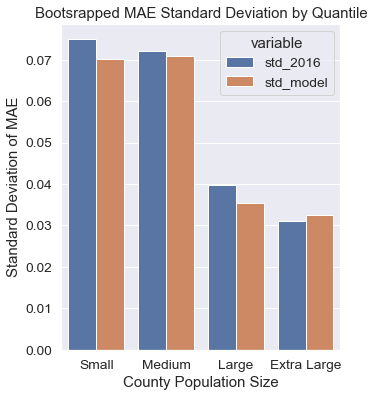

In [74]:
plt.subplots(figsize=(5,6))
sns.barplot(data=df_q_std,x='pop_quantiles_labels',y='value',hue='variable')
plt.ylabel('Standard Deviation of MAE')
plt.xlabel('County Population Size')
plt.title('Bootsrapped MAE Standard Deviation by Quantile')
plt.show()

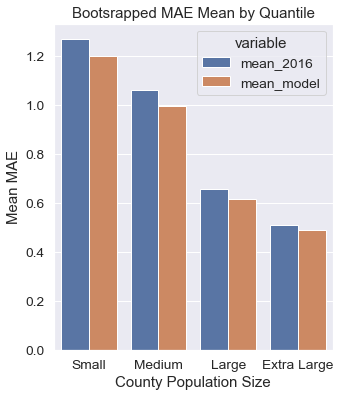

In [76]:
plt.subplots(figsize=(5,6))
sns.barplot(data=df_q_mean,x='pop_quantiles_labels',y='value',hue='variable',hue_order = ['mean_2016','mean_model'])
plt.ylabel('Mean MAE')
plt.xlabel('County Population Size')
plt.title('Bootsrapped MAE Mean by Quantile')
plt.show()